In [1]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score
from torchmetrics.utilities.data import dim_zero_cat
from utils import create_dataloader, create_efficientnet, create_confusion_matrix_plot

c:\Users\hornh\user_root\venvs\cv_prakt_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\hornh\user_root\venvs\cv_prakt_env\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
BATCH_SIZE = 16
DATA_DIR = '../data/'
MODEL_PATH = r'../models\effnet,lr=0.00245,EP=25,BS=64,Nov09_00-18-40\epoch24.pth'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
_, _, test_loader = create_dataloader(BATCH_SIZE, DATA_DIR)
model = create_efficientnet()
model = torch.load(MODEL_PATH)

Using cache found in C:\Users\hornh/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub
C:\Users\hornh/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\common.py:13: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(
C:\Users\hornh/.cache\torch\hub\NVIDIA_DeepLearningExamples_torchhub\PyTorch\Classification\ConvNets\image_classification\models\efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


In [4]:
accuracy_metric = BinaryAccuracy().to(device)
f1_score_metric = BinaryF1Score().to(device)

In [5]:
model.eval()
with torch.no_grad():
    epoch_labels, epoch_predictions = [], []
    
    f1_score_metric.reset() 
    accuracy_metric.reset()

    for data in tqdm(test_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs).reshape(-1)
        outputs = torch.sigmoid(outputs)
        bin_outputs = torch.round(outputs)

        accuracy_metric.update(bin_outputs, labels)
        f1_score_metric.update(bin_outputs, labels)
        epoch_labels.append(labels)
        epoch_predictions.append(outputs)

    tp, fp, tn, fn = f1_score_metric.tp, f1_score_metric.fp, f1_score_metric.tn, f1_score_metric.fn
    f1 = f1_score_metric.compute()
    acc = accuracy_metric.compute()
    

100%|██████████| 39/39 [00:32<00:00,  1.21it/s]


In [6]:
print('F1-Score:', f1.cpu().item())
print('Accuracy:', acc.cpu().item())

F1-Score: 0.8914549946784973
Accuracy: 0.8493589758872986


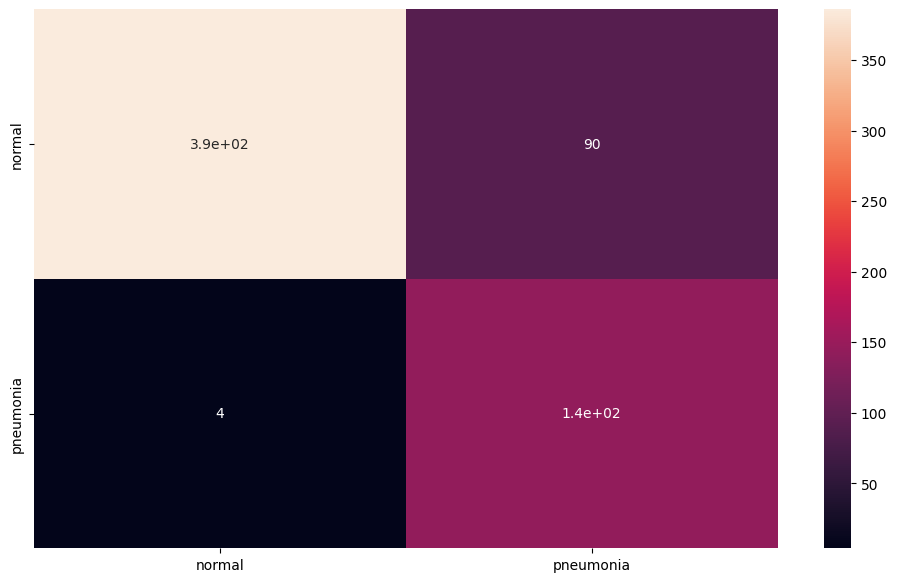

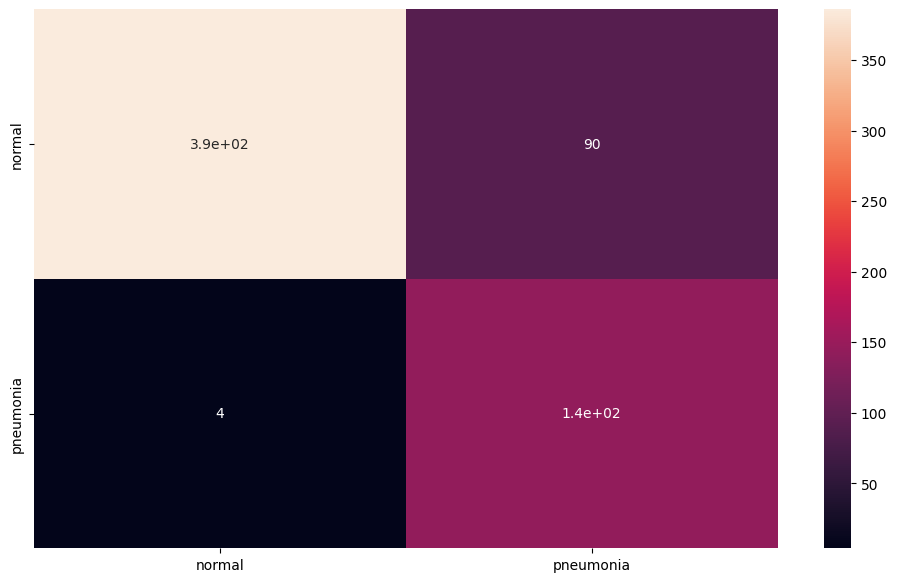

In [7]:
create_confusion_matrix_plot(tp, fp, tn, fn)

In [8]:
def plot_precision_recall_curve(true_labels, predicted_scores):
    # Convert torch tensors to numpy arrays
    true_labels = true_labels.cpu().numpy()
    predicted_scores = predicted_scores.cpu().numpy()

    # Compute precision and recall
    precision, recall, _ = precision_recall_curve(true_labels, predicted_scores)

    # Plot the PR curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.show()

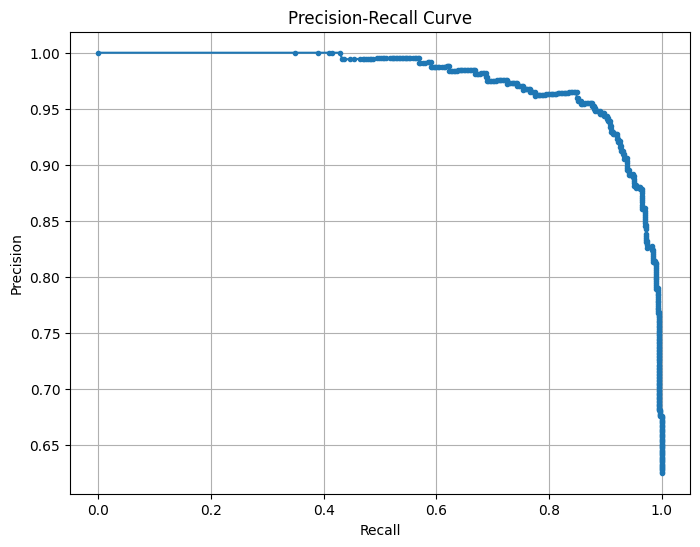

In [9]:
plot_precision_recall_curve(dim_zero_cat(epoch_labels), dim_zero_cat(epoch_predictions))